In [182]:
# -------------------------------------------------------------------------------------------------------------------
# Course name - Exploratory data analysis
# Course code - DSC530
# Week 7 assignment
# Script name - Shekhar530Week7.ipynb
# Creator - Manish Shekhar
# Date created - Jan 22nd to Jan 27th 2023
# -------------------------------------------------------------------------------------------------------------------

### Exercise 7-1 
#### Step 1 - Reading, and cleaning the NSFG respondent and pregnancy data file

In [133]:
# [Manish] - Importing required libraries

import sys
import numpy as np
import thinkstats2
import matplotlib.pyplot as plt
import math
import statistics
import seaborn as sns
import pandas as pd

from collections import defaultdict



# [Manish] - Reading the data file (NSFG repondent data) and cleaning it
dct_file='/Users/mshekhar/Downloads/2002FemResp.dct'
dat_file='/Users/mshekhar/Downloads/2002FemResp.dat.gz'
dct = thinkstats2.ReadStataDct(dct_file)
df_resp = dct.ReadFixedWidth(dat_file, compression='gzip', nrows=None)


# [Manish] - Reading the data file (NSFG pregnancy data)
dct_file='/Users/mshekhar/Downloads/2002FemPreg.dct'
dat_file='/Users/mshekhar/Downloads/2002FemPreg.dat.gz'
dct = thinkstats2.ReadStataDct(dct_file)
df_preg = dct.ReadFixedWidth(dat_file, compression='gzip')


# [Manish] - User defined function to clean the pregnancy data 
def CleanFemPreg(df):
    """Recodes variables from the pregnancy frame.
    df: DataFrame
    """
    # mother's age is encoded in centiyears; convert to years
    df.agepreg /= 100.0

    # birthwgt_lb contains at least one bogus value (51 lbs)
    # replace with NaN
    df.loc[df.birthwgt_lb > 20, 'birthwgt_lb'] = np.nan
    
    # replace 'not ascertained', 'refused', 'don't know' with NaN
    na_vals = [97, 98, 99]
    df.birthwgt_lb.replace(na_vals, np.nan, inplace=True)
    df.birthwgt_oz.replace(na_vals, np.nan, inplace=True)
    df.hpagelb.replace(na_vals, np.nan, inplace=True)

    df.babysex.replace([7, 9], np.nan, inplace=True)
    df.nbrnaliv.replace([9], np.nan, inplace=True)

    # birthweight is stored in two columns, lbs and oz.
    # convert to a single column in lb
    # NOTE: creating a new column requires dictionary syntax,
    # not attribute assignment (like df.totalwgt_lb)
    df['totalwgt_lb'] = df.birthwgt_lb + df.birthwgt_oz / 16.0    

    # due to a bug in ReadStataDct, the last variable gets clipped;
    # so for now set it to NaN
    df.cmintvw = np.nan
    
    

# [Manish]- cleaning the data in pregnancy file
CleanFemPreg(df_preg)

In [102]:
# creating a data filter with live births as we are conserned with finding about first pregnancy tenure
filter_live_preg = df_preg['outcome']==1
filter_live_preg.value_counts()

True     9148
False    4445
Name: outcome, dtype: int64

In [103]:
# create a data frame with live births only
df_live_preg = df_preg[filter_live_preg]
df_live_preg['outcome'].value_counts()

1    9148
Name: outcome, dtype: int64

In [104]:
# drop na from both the columns
df_live_preg = df_live_preg.dropna(subset=['agepreg', 'totalwgt_lb'])

#### Step 2 - Create a scatterplot between child's birth weight and mother's age

In [105]:
# As data is loaded now, lets look create variables for mother's age at pregnancy and 
# total weight (derived from weight in pound and weight in ounce cleaned up column)
mothers_age=df_live_preg['agepreg']
childs_weight_birth=df_live_preg['totalwgt_lb']

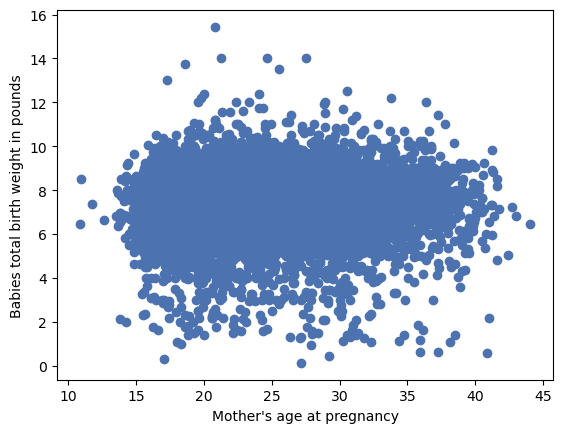

In [106]:
# Plotting a basic scatterplot using pyplot.plot
plt.plot(mothers_age,childs_weight_birth,'o')
# label the axis
plt.xlabel("Mother's age at pregnancy")
plt.ylabel("Babies total birth weight in pounds")
plt.show()

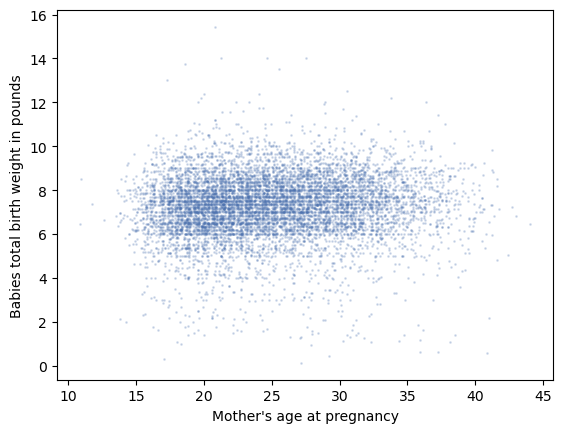

In [107]:
# As the plot is too busy i.e. overplotted lets replot decreasing the transparency using alpha parameter
# In addition we can try reducing the markersize to 1
plt.plot(mothers_age,childs_weight_birth,'o',alpha=0.2,markersize=1)
plt.xlabel("Mother's age at pregnancy")
plt.ylabel("Babies total birth weight in pounds")
plt.show()

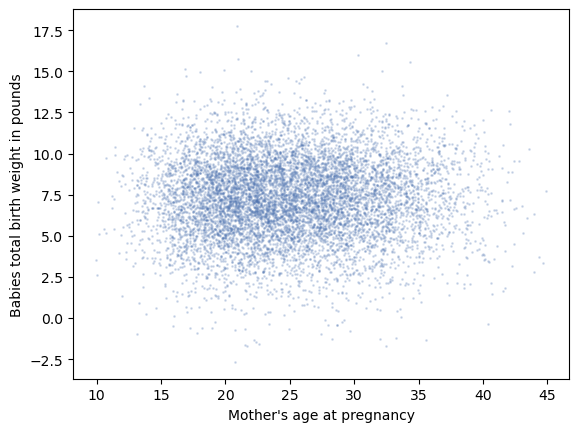

In [108]:
# As we can see data points in discrete rows and columns we can add some random data points to fill in using jittering
age_jitter = mothers_age + np.random.normal(0, 2, size=len(df_live_preg))
weight_jitter = childs_weight_birth + np.random.normal(0, 2, size=len(df_live_preg))
plt.plot(age_jitter, weight_jitter, 'o', alpha=0.2, markersize=1)
plt.xlabel("Mother's age at pregnancy")
plt.ylabel("Babies total birth weight in pounds")
plt.show()

In [121]:
################################################## OBSERVATION ######################################################
# The scatterplot shows a weak relationship between the variables but it is hard to see clearly.
#####################################################################################################################

In [122]:
np.arange(10, 48, 3)

array([10, 13, 16, 19, 22, 25, 28, 31, 34, 37, 40, 43, 46])

#### Step 3 - Creating percentiles of baby's weight and plotting it against the mother's age bins

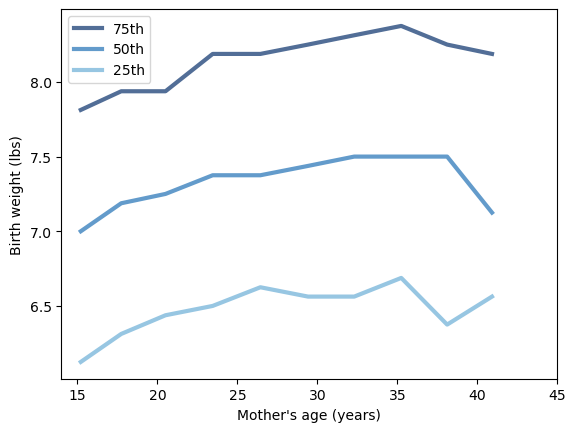

In [131]:
# Bin the data by age and plot percentiles of weight for each bin.
def BinnedPercentiles(df):
    bins = np.arange(10, 48, 3)
    indices = np.digitize(df.agepreg, bins)
    groups = df.groupby(indices)

    ages = [group.agepreg.mean() for i, group in groups][1:-1]
    cdfs = [thinkstats2.Cdf(group.totalwgt_lb) for i, group in groups][1:-1]

    thinkplot.PrePlot(3)
    for percent in [75, 50, 25]:
        weights = [cdf.Percentile(percent) for cdf in cdfs]
        label = '%dth' % percent
        thinkplot.Plot(ages, weights, label=label)

    thinkplot.Config(xlabel="Mother's age (years)",
                     ylabel='Birth weight (lbs)',
                     xlim=[14, 45], legend=True)

    
BinnedPercentiles(df_live_preg)

In [142]:
# Creating custom age bins to be able to show all box and whiskers
bins = np.arange(10, 48, 3)
df_live_preg['MyAgeBins'] = pd.cut(mothers_age, bins)

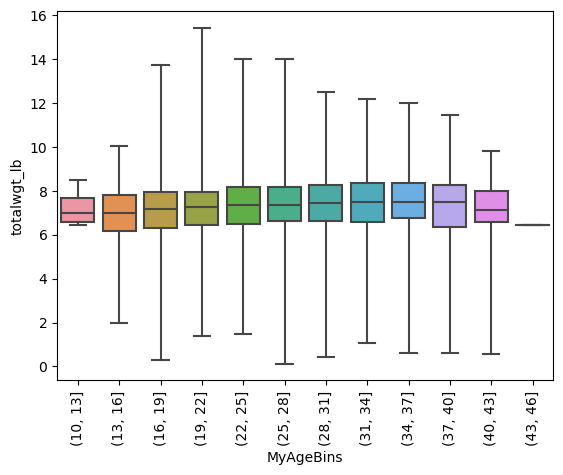

In [143]:
# Creating box plot to show weights percentiles by age bins
boxp = sns.boxplot(x=df_live_preg['MyAgeBins'], y=childs_weight_birth, data=df_live_preg, whis=10)
plt.setp(boxp.get_xticklabels(), rotation=90)
plt.show()

In [44]:
################################################# OBSERVATION #######################################################
# Plotting percentiles of weight versus age suggests that the
# relationship is non-linear.  Birth weight increases more quickly
# in the range of mother's age from 15 to 25.  After that, the effect is weaker.
#####################################################################################################################

#### Step 4 - Calculating Pearson's and Spearman's correlation coefficients

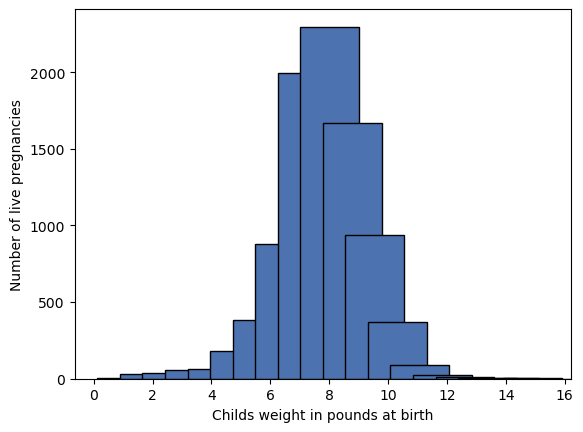

In [94]:
# Checking if distribution of total_wt and mother's age is approximately normal
plt.style.use('seaborn-deep')
plt.hist(np.array(childs_weight_birth), width = 2, edgecolor = "black", bins=20)
plt.xlabel('Childs weight in pounds at birth')
plt.ylabel('Number of live pregnancies')
plt.show()


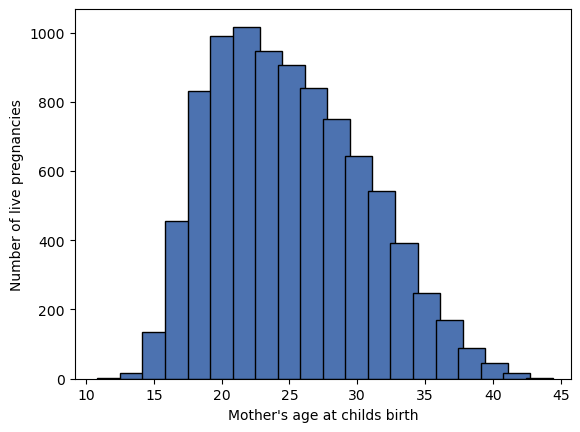

In [95]:
plt.style.use('seaborn-deep')
plt.hist(np.array(mothers_age), width = 2, edgecolor = "black", bins=20)
plt.xlabel("Mother's age at childs birth")
plt.ylabel('Number of live pregnancies')
plt.show()

In [48]:
# We can see that both variables have approximately normal distribution. 
# We can thus consider the value of Pearson' correlation.

In [96]:
# Calculating Pearson's correlation
print('Corr', thinkstats2.Corr(mothers_age, childs_weight_birth))
print('SpearmanCorr', thinkstats2.SpearmanCorr(mothers_age, childs_weight_birth))

Corr 0.06883397035410911
SpearmanCorr 0.09461004109658226


In [ ]:
################################################### OBSERVATION #####################################################
# The correlations support weak positive relationship between age and weight of baby.  
# Pearson's is around 0.068, Spearman's is around 0.09.  
# The difference between them suggests some influence of outliers or a non-linear relationsip.
#####################################################################################################################